# Detecting malicious URLs

In [1]:
# GENERAL
import os
import sys
sys.path.append('../')
import math
import re
import datetime
import time
import pandas as pd
import matplotlib as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import warnings
import pathlib

In [2]:
# IPYTHON TWEAKS
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #display all results
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina' #see plots in retina displays
%reload_ext autoreload
%autoreload 2
%matplotlib inline

For this experiment, we will be using the Sklearn and Fast.ai libraries to assist us across the data science process.

In [3]:
# SKLEARN
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, f1_score ,recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [4]:
# FAST.AI
from fastai.tabular import *

Here we import some libraries to assist us in pulling, parsing, and transforming our domain information.

In [5]:
# FEATURE HELPERS
from helpers.feature_helpers import *

In [6]:
# # DOMAIN SPECIFIC LIBRARIES
# import tldextract
# from urllib.parse import urlparse
# from socket import gethostbyname, gaierror, timeout
# import whois
# import socket

## Data Ingestion

### The bad stuff

Exploring the Internet, we find a nice list of maliciousness, provided by http://www.malwaredomainlist.com/

Link: http://www.malwaredomainlist.com/hostslist/hosts.txt

In [7]:
# Choose malicious data set
# ['hosts.txt', 'phishtank.csv']
filename = 'phishtank.csv'

In [8]:
# Ingest Alex top 1 million urls 
columns = ['url', 'phish_detail_url', 'submission_time', 'verified', 'verification', 'online', 'target']

mal_df = pd.read_csv('../data/' + filename, 
                     encoding = "ISO-8859-1",
                     header=0,
                     index_col=0,
                     names = columns)[['url']]

In [9]:
# Randomly sample 500 elements from your dataframe
mal_sample_df = mal_df.sample(n=5000)

In [10]:
# Label malicious stuff
mal_sample_df.loc[:, 'class'] = 'malicious'

In [11]:
mal_sample_df.head()

,url,class
5356311,http://ug-i.tripod.com/,malicious
5085481,http://avelingproduce.co.uk/ze/?ksd&amp;email&...,malicious
6090826,http://tmff.us/trade2/support/host/Alibaba.com...,malicious
5812400,https://vagdevigurazala.in/login/customer_cent...,malicious
6108315,https://onedrive.live.com/redir?resid=9EECAA1F...,malicious


In [12]:
pd.DataFrame(mal_sample_df.isnull().sum(), columns=['missing_count'])

,missing_count
url,0
class,0


### The mostly benign stuff

In [13]:
# Ingest Alex top 1 million urls 
columns = ['url']

benign_df = pd.read_csv('../data/top-1m.csv', 
                     encoding = "ISO-8859-1", 
                     names = columns)

In [14]:
benign_sample_df = benign_df.iloc[0:5000]

In [15]:
benign_sample_df.loc[:, 'class'] = 'benign'

In [16]:
benign_sample_df.head()

,url,class
1,google.com,benign
2,youtube.com,benign
3,baidu.com,benign
4,facebook.com,benign
5,qq.com,benign


In [17]:
pd.DataFrame(benign_sample_df.isnull().sum(), columns=['missing_count'])

,missing_count
url,0
class,0


### IANA Address Space

In [18]:
# Ingest IANA dataset
iana = pd.read_csv("https://www.iana.org/assignments/ipv4-address-space/ipv4-address-space.csv", sep=",")
iana.columns = iana.columns.str.strip().str.lower()
iana.rename(columns={'Prefix': 'prefix'}, inplace=True)

# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float', errors='ignore').astype(int).astype(str)

iana.head()

,prefix,designation,date,whois,rdap,status [1],note
0,0,IANA - Local Identification,1981-09,NaN,NaN,RESERVED,[2]
1,1,APNIC,2010-01,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED,NaN
2,2,RIPE NCC,2009-09,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED,NaN
3,3,Administered by ARIN,1994-05,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN
4,4,Administered by ARIN,1992-12,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN


In [19]:
# Frames we would like to merge
full_data = [mal_sample_df, benign_sample_df]
print(mal_sample_df.shape, benign_sample_df.shape)

(5000, 2) (5000, 2)


### Feature Engineering

In [20]:
tqdm.pandas()

for df in full_data:
    df[['domain_name', 
        'domain',
        'suffix']] = df.progress_apply(unpack_url, axis=1)

100%|██████████| 5000/5000 [00:02<00:00, 1832.15it/s]


In [21]:
tqdm.pandas()

# Generate whois data
for df in full_data:
    df[['create_date', 
        'updated_date', 
        'expiration_date', 
        'state',
        'country', 
        'status',
        'emails',
        'whois_server',
        'registrar']]  = df.progress_apply(whois_info, axis=1)

100%|██████████| 5000/5000 [2:06:16<00:00,  1.21s/it]   


In [22]:
tqdm.pandas()

# Generate host ip
for df in full_data:
    df['host_ip'] = df['domain_name'].progress_apply(lambda x: host_ip(x))

100%|██████████| 5000/5000 [26:16<00:00,  3.17it/s]  


In [23]:
# Save checkpoint
benign_sample_df.to_csv(str(datetime.now().day) + "_benign.csv")
mal_sample_df.to_csv(str(datetime.now().day) + "_malicious.csv")

In [24]:
tqdm.pandas()

# Generate number of special characters
for df in full_data:
    df['specials'] = df['domain_name'].progress_apply(lambda x: len(re.sub('[\w]+' ,'', x)))

100%|██████████| 5000/5000 [00:00<00:00, 341951.12it/s]


In [25]:
# Generate prefix
for df in full_data:
    df.loc[:, 'prefix'] = get_prefix(df['host_ip']).values

In [26]:
# Calculate entropy
for df in full_data:
    df['entropy'] = df['domain_name'].apply(lambda x: entropy(str(x)))

In [27]:
# Calculate digits percentage
for df in full_data:
    df.loc[:, 'number_digits'] = get_number_digits(df['domain_name']).values
    df.loc[:, 'string_length'] = get_string_length(df['domain_name']).values
    df['digits_percentage'] = df.loc[:, 'number_digits'].div(df['string_length'])

In [28]:
tqdm.pandas()

# Generate create time bins
for df in full_data:
    df['create_date'] = df['create_date'].apply(lambda x: x[0] if type(x) is list else x )
    df.loc[df['create_date'].astype(str).str.contains('Aug'), 'create_date'] = datetime(1996,8,1)
    df['create_date'].fillna(datetime.now(), inplace=True)
    df['create_date'] = pd.to_datetime(df['create_date'], errors='coerce')
    df['creation_bins'] = df['create_date'].progress_apply(lambda x: ts_historic_bins(x))
    
# Generate update time bins
for df in full_data:
    df['updated_date'] = df['updated_date'].apply(lambda x: x[0] if type(x) is list else x )
    df.loc[df['updated_date'].astype(str).str.contains('Aug'), 'updated_date'] = datetime(1996,8,1)
    df['updated_date'].fillna(datetime.now(), inplace=True)
    df['updated_date'] = pd.to_datetime(df['updated_date'], errors='coerce') 
    df['updated_bins'] = df['updated_date'].progress_apply(lambda x: ts_historic_bins(x))

100%|██████████| 5000/5000 [00:00<00:00, 56885.34it/s]


In [29]:
tqdm.pandas()

# Generate expire time bins
for df in full_data:
    df['expiration_date'] = df['expiration_date'].apply(lambda x: x[0] if type(x) is list else x )
    df.loc[df['expiration_date'].astype(str).str.contains('Aug'), 'expiration_date'] = datetime(1996,8,1)
    df['expiration_date'].fillna(datetime.now(), inplace=True)
    df['expiration_date'] = pd.to_datetime(df['expiration_date'], errors='coerce') 
    df['expiration_bins'] = df['expiration_date'].progress_apply(lambda x: ts_future_bins(x))

100%|██████████| 5000/5000 [00:00<00:00, 58090.28it/s]


In [30]:
tqdm.pandas()

# Generate delta between create and expiry
def delta_create_expiry(row):
    return (row['expiration_date'] - row['create_date']).days

for df in full_data:
    df['delta_create_expiry'] = df.progress_apply(delta_create_expiry, axis=1)

100%|██████████| 5000/5000 [00:00<00:00, 17718.48it/s]


In [31]:
# Generate days old feature
for df in full_data:
    # Cast domain age columnt to datetime
    df['create_date'] = pd.to_datetime(df['create_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Calculate the age of the domain
    df['days_old'] = pd.datetime.today().date() - df['create_date'].dt.date

    # Cast age to an integer
    df['days_old'] = df['days_old'].astype(str).str.extract("(\d+)")

In [32]:
# Generate dates since update feature
for df in full_data:
    # Cast update date column to datetime
    df['updated_date'] = pd.to_datetime(df['updated_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Calculate the days between now and the last update to the domain
    df['days_since_update'] = pd.datetime.today().date() - df['updated_date'].dt.date

    # Cast age to an integer
    df['days_since_update'] = df['days_since_update'].astype(str).str.extract("(\d+)")

In [33]:
# Generate days till expiration feature
for df in full_data:
    # Cast expiration date column to datetime
    df['expiration_date'] = pd.to_datetime(df['expiration_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Calculate the days between now and expiration of the domain
    df['days_to_exp'] = df['expiration_date'].dt.date - pd.datetime.today().date()

    # Cast age to an integer
    df['days_to_exp'] = df['days_to_exp'].astype(str).str.extract("(\d+)")

In [34]:
# Stringify lists with delimiter
def join_list(x):
    if type(x) is list:
        return ','.join(x)
    else:
        return x

# Clean up status column
for df in full_data:
    df['status'] = df[['status']].fillna('missing')
    df['status'] = df['status'].apply(join_list)
    df['status_str'] = df['status'].str.replace('((http|https)\:+\/\/.*?(\,|\s|$))', ',').str.replace('\(|\)|\s+|\-+|\.', '').str.strip().str.lower()

In [35]:
# Clean missing values
for df in full_data:
    df['state'] = df['state'].fillna('missing')
    df['country'] = df['country'].fillna('missing')

## Exploratory Data Analysis

In [36]:
# benign_sample_df['create_date'] = pd.to_datetime(benign_sample_df['create_date'], errors='coerce')
# benign_sample_df['create_date'].groupby([benign_sample_df["create_date"].dt.year, benign_sample_df["create_date"].dt.month]).count().plot(kind="bar")

In [37]:
# benign_sample_df['updated_date'] = pd.to_datetime(benign_sample_df['updated_date'], errors='coerce')
# benign_sample_df['updated_date'].groupby([benign_sample_df["updated_date"].dt.year, benign_sample_df["updated_date"].dt.month]).count().plot(kind="bar")

In [38]:
# benign_sample_df['expiration_date'] = pd.to_datetime(benign_sample_df['expiration_date'], errors='coerce')
# benign_sample_df['expiration_date'].groupby([benign_sample_df["expiration_date"].dt.year, benign_sample_df["expiration_date"].dt.month]).count().plot(kind="bar")

In [39]:
# mal_sample_df['create_date'] = pd.to_datetime(mal_sample_df['create_date'], errors='coerce')
# mal_sample_df['create_date'].groupby([mal_sample_df["create_date"].dt.year, mal_sample_df["create_date"].dt.month]).count().plot(kind="bar")

In [40]:
# mal_sample_df['updated_date'] = pd.to_datetime(mal_sample_df['updated_date'], errors='coerce')
# mal_sample_df['updated_date'].groupby([mal_sample_df["updated_date"].dt.year, mal_sample_df["updated_date"].dt.month]).count().plot(kind="bar")

In [41]:
# mal_sample_df['expiration_date'] = pd.to_datetime(mal_sample_df['expiration_date'], errors='coerce')
# mal_sample_df['expiration_date'].groupby([mal_sample_df["expiration_date"].dt.year, mal_sample_df["expiration_date"].dt.month]).count().plot(kind="bar")

### Prepare data for modeling

In [73]:
# Join goodness and badness
master_df = pd.concat(full_data).reset_index(drop=True)
idx = np.random.permutation(master_df.index)
master_df = master_df.reindex(idx)
master_df.shape

(10000, 29)

In [74]:
master_df

,url,class,domain_name,domain,suffix,create_date,updated_date,expiration_date,state,country,...,string_length,digits_percentage,creation_bins,updated_bins,expiration_bins,delta_create_expiry,days_old,days_since_update,days_to_exp,status_str
9505,filerio.in,benign,filerio.in,filerio,in,2012-04-19 11:37:40.000000,2019-01-17 10:50:17.000000,2020-04-19 11:37:40.000000,missing,missing,...,10,0.000000,over 5 years,between 180 days and 365 days,between 180 days and 365 days,2922.0,2649,185,273,"clienttransferprohibited,"
737,http://103.52.188.138/login/online.americanexp...,malicious,,103.52.188.138,,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2019-07-21 17:10:19.926772,missing,missing,...,0,NaN,last 30 days,last 30 days,within 30 days,0.0,0,0,0,missing
7127,bab.la,benign,bab.la,bab,la,2006-10-26 01:00:00.000000,2019-03-25 21:38:37.000000,2019-10-26 23:59:59.000000,missing,missing,...,6,0.000000,over 5 years,between 60 days and 180 days,between 60 days and 180 days,4748.0,4651,118,97,"ok,"
7785,bancsabadell.com,benign,bancsabadell.com,bancsabadell,com,1997-02-17 05:00:00.000000,2019-02-17 01:40:56.000000,2020-02-18 05:00:00.000000,Barcelona,ES,...,16,0.000000,over 5 years,between 60 days and 180 days,between 180 days and 365 days,8401.0,8189,154,212,"ok,ok,"
5182,zillow.com,benign,zillow.com,zillow,com,2004-09-16 21:16:58.000000,2018-04-26 19:19:26.000000,2027-11-11 04:59:59.000000,Washington,US,...,10,0.000000,over 5 years,over a year,over 5 years,8455.0,5421,451,3035,"clientdeleteprohibited,clientrenewprohibited,c..."
2122,http://clk.im/VvPe,malicious,clk.im,clk,im,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2025-09-30 00:59:59.000000,missing,missing,...,6,0.000000,last 30 days,last 30 days,over 5 years,2262.0,0,0,2263,missing
7543,quasa.io,benign,quasa.io,quasa,io,2017-09-05 19:56:15.000000,2018-07-10 17:59:17.000000,2019-09-05 19:56:15.000000,missing,missing,...,8,0.000000,over a year,over a year,between 30 and 60 days,730.0,684,376,46,"clienttransferprohibited,"
1584,http://morfil-fm.blogcu.com/,malicious,blogcu.com,blogcu,com,2005-02-16 14:52:48.000000,2019-01-15 09:56:00.000000,2024-02-16 14:52:48.000000,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,...,10,0.000000,over 5 years,between 180 days and 365 days,over a two years,6939.0,5268,187,1671,"clienttransferprohibited,clienttransferprohibi..."
9298,mover.uz,benign,mover.uz,mover,uz,2011-03-31 00:00:00.000000,2018-01-29 00:00:00.000000,2021-04-06 00:00:00.000000,missing,missing,...,8,0.000000,over 5 years,over a year,over a year,3659.0,3034,538,625,active
1490,http://kntechpower.wordpress.com/2016/09/19/ya...,malicious,wordpress.com,wordpress,com,2000-03-03 12:13:23.000000,2017-01-12 22:53:10.000000,2020-03-03 12:13:23.000000,CA,US,...,13,0.000000,over 5 years,over a two years,between 180 days and 365 days,7305.0,7079,920,226,"clientdeleteprohibited,clienttransferprohibite..."


In [75]:
pd.concat([master_df.drop('status_str', axis=1), master_df['status_str'].str.get_dummies(sep=',')], axis=1)

,url,class,domain_name,domain,suffix,create_date,updated_date,expiration_date,state,country,...,unassignable,unverified,updateprohibited,verified,verifiedid@sgmandatory,verifiedid@sgnotrequired,verifiedid@sgokverifiedbyadmincontact,yannawa<br>adminpostalcode:10120<br>admincountry:th<br>adminphone:+01295229478889<br>adminphoneext:<br>adminfax:+01295115478912<br>adminfaxext:<br>adminemail:admin@areacoth<br>registryregistrationid:<br>techname:soponpornchockchai<br>techorganization:agencyforrealestateaffairscoltd<br>techstreet:55/4042nonseerd,yannawa<br>registrationpostalcode:10120<br>registrationcountry:th<br>registrationphone:+01295229478889<br>registrationphoneext:<br>registrationfax:+01295115478912<br>registrationfaxext:<br>registrationemail:admin@areacoth<br>registryregistrationid:<br>adminname:soponpornchockchai<br>adminorganization:agencyforrealestateaffairscoltd<br>adminstreet:55/4042nonseerd,yannawa<br>techpostalcode:10120<br>techcountry:th<br>techphone:+01295229478889<br>techphoneext:<br>techfax:+01295115478912<br>techfaxext:<br>techemail:admin@areacoth<br>nameserver:ns22appservhostingcom<br>nameserver:ns22appservnetworkcom<br>dnssec:unsigned<br>urloftheicannwhoisdataproblemreportingsystem:
9505,filerio.in,benign,filerio.in,filerio,in,2012-04-19 11:37:40.000000,2019-01-17 10:50:17.000000,2020-04-19 11:37:40.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,0
737,http://103.52.188.138/login/online.americanexp...,malicious,,103.52.188.138,,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2019-07-21 17:10:19.926772,missing,missing,...,0,0,0,0,0,0,0,0,0,0
7127,bab.la,benign,bab.la,bab,la,2006-10-26 01:00:00.000000,2019-03-25 21:38:37.000000,2019-10-26 23:59:59.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,0
7785,bancsabadell.com,benign,bancsabadell.com,bancsabadell,com,1997-02-17 05:00:00.000000,2019-02-17 01:40:56.000000,2020-02-18 05:00:00.000000,Barcelona,ES,...,0,0,0,0,0,0,0,0,0,0
5182,zillow.com,benign,zillow.com,zillow,com,2004-09-16 21:16:58.000000,2018-04-26 19:19:26.000000,2027-11-11 04:59:59.000000,Washington,US,...,0,0,0,0,0,0,0,0,0,0
2122,http://clk.im/VvPe,malicious,clk.im,clk,im,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2025-09-30 00:59:59.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,0
7543,quasa.io,benign,quasa.io,quasa,io,2017-09-05 19:56:15.000000,2018-07-10 17:59:17.000000,2019-09-05 19:56:15.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,0
1584,http://morfil-fm.blogcu.com/,malicious,blogcu.com,blogcu,com,2005-02-16 14:52:48.000000,2019-01-15 09:56:00.000000,2024-02-16 14:52:48.000000,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,...,0,0,0,0,0,0,0,0,0,0
9298,mover.uz,benign,mover.uz,mover,uz,2011-03-31 00:00:00.000000,2018-01-29 00:00:00.000000,2021-04-06 00:00:00.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,0
1490,http://kntechpower.wordpress.com/2016/09/19/ya...,malicious,wordpress.com,wordpress,com,2000-03-03 12:13:23.000000,2017-01-12 22:53:10.000000,2020-03-03 12:13:23.000000,CA,US,...,0,0,0,0,0,0,0,0,0,0


In [83]:
master_df['status_str'].str.get_dummies(sep=',').columns

74

In [84]:
master_df = master_df.merge(iana[['prefix', 'designation']], how='left', on='prefix')

In [79]:
master_df.columns

Index(['url', 'class', 'domain_name', 'domain', 'suffix', 'create_date',
       'updated_date', 'expiration_date', 'state', 'country', 'status',
       'emails', 'whois_server', 'registrar', 'host_ip', 'specials', 'prefix',
       'entropy', 'number_digits', 'string_length', 'digits_percentage',
       'creation_bins', 'updated_bins', 'expiration_bins',
       'delta_create_expiry', 'days_old', 'days_since_update', 'days_to_exp',
       'status_str'],
      dtype='object')

In [68]:
display(master_df)

,url,class,domain_name,domain,suffix,create_date,updated_date,expiration_date,state,country,...,unverified,updateprohibited,verified,verifiedid@sgmandatory,verifiedid@sgnotrequired,verifiedid@sgokverifiedbyadmincontact,yannawa<br>adminpostalcode:10120<br>admincountry:th<br>adminphone:+01295229478889<br>adminphoneext:<br>adminfax:+01295115478912<br>adminfaxext:<br>adminemail:admin@areacoth<br>registryregistrationid:<br>techname:soponpornchockchai<br>techorganization:agencyforrealestateaffairscoltd<br>techstreet:55/4042nonseerd,yannawa<br>registrationpostalcode:10120<br>registrationcountry:th<br>registrationphone:+01295229478889<br>registrationphoneext:<br>registrationfax:+01295115478912<br>registrationfaxext:<br>registrationemail:admin@areacoth<br>registryregistrationid:<br>adminname:soponpornchockchai<br>adminorganization:agencyforrealestateaffairscoltd<br>adminstreet:55/4042nonseerd,yannawa<br>techpostalcode:10120<br>techcountry:th<br>techphone:+01295229478889<br>techphoneext:<br>techfax:+01295115478912<br>techfaxext:<br>techemail:admin@areacoth<br>nameserver:ns22appservhostingcom<br>nameserver:ns22appservnetworkcom<br>dnssec:unsigned<br>urloftheicannwhoisdataproblemreportingsystem:,designation
0,http://54.38.55.240/canada-revenue-agencyid325...,malicious,,54.38.55.240,,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2019-07-21 17:10:19.926772,missing,missing,...,0,0,0,0,0,0,0,0,0,IANA - Local Identification
1,http://newsosent.com/information/docu/a/,malicious,newsosent.com,newsosent,com,2009-03-19 06:32:21.000000,2019-03-25 00:35:36.000000,2020-03-19 06:32:21.000000,Metro Manila,PH,...,0,0,0,0,0,0,0,0,0,ARIN
2,netvasco.com.br,benign,netvasco.com.br,netvasco,com.br,2019-07-21 17:10:19.530107,2019-07-21 17:10:19.774941,2019-07-21 17:10:20.042403,missing,missing,...,0,0,0,0,0,0,0,0,0,ARIN
3,http://email.office-email.com.au/c/eJw1i0sOgyA...,malicious,office-email.com.au,office-email,com.au,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2019-07-21 17:10:19.926772,missing,missing,...,0,0,0,0,0,0,0,0,0,APNIC
4,significados.com.br,benign,significados.com.br,significados,com.br,2019-07-21 17:10:19.530107,2019-07-21 17:10:19.774941,2019-07-21 17:10:20.042403,missing,missing,...,0,0,0,0,0,0,0,0,0,Administered by ARIN
5,booksdescr.org,benign,booksdescr.org,booksdescr,org,2019-07-21 17:10:19.530107,2019-07-21 17:10:19.774941,2019-07-21 17:10:20.042403,missing,missing,...,0,0,0,0,0,0,0,0,0,RIPE NCC
6,https://urlaubsplus.de/sparkasse,malicious,urlaubsplus.de,urlaubsplus,de,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2019-07-21 17:10:19.926772,missing,missing,...,0,0,0,0,0,0,0,0,0,RIPE NCC
7,http://www.mariagraziagiove.com/ibdg/phpmailer...,malicious,mariagraziagiove.com,mariagraziagiove,com,2019-07-21 17:10:19.428149,2019-07-21 17:10:19.654291,2019-07-21 17:10:19.926772,missing,missing,...,0,0,0,0,0,0,0,0,0,RIPE NCC
8,actcorp.in,benign,actcorp.in,actcorp,in,2014-06-03 11:55:18.000000,2019-05-18 08:33:28.000000,2024-06-03 11:55:18.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,APNIC
9,curiouscat.me,benign,curiouscat.me,curiouscat,me,2016-04-01 23:51:14.000000,2018-04-12 04:18:06.000000,2020-04-01 23:51:14.000000,missing,missing,...,0,0,0,0,0,0,0,0,0,ARIN


In [78]:
mal_sample_df['status'].unique()

array(['clientTransferProhibited https://icann.org/epp#clientTransferProhibited,clientTransferProhibited http://www.icann.org/epp#clientTransferProhibited',
       'Registered until expiry date.',
       'clientRenewProhibited https://icann.org/epp#clientRenewProhibited,clientDeleteProhibited https://icann.org/epp#clientDeleteProhibited,clientTransferProhibited https://icann.org/epp#clientTransferProhibited,clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited,clientTransferProhibited http://www.icann.org/epp#clientTransferProhibited,clientUpdateProhibited http://www.icann.org/epp#clientUpdateProhibited,clientRenewProhibited http://www.icann.org/epp#clientRenewProhibited,clientDeleteProhibited http://www.icann.org/epp#clientDeleteProhibited',
       'clientTransferProhibited http://www.icann.org/epp#clientTransferProhibited', ...,
       'serverTransferProhibited https://icann.org/epp#serverTransferProhibited,clientTransferProhibited https://icann.org/epp#clientTransferPr

### Modeling

In [46]:
procs = [FillMissing, Categorify, Normalize]

In [85]:
drops = ['url', 'domain_name', 'domain', 'create_date',
'updated_date', 'expiration_date', 'state', 'country', 'status', 
'emails', 'whois_server', 'registrar', 'host_ip', 'prefix', 'status_str']

sample_df = master_df.drop(drops, axis=1)

In [86]:
sample_df.shape

(10000, 15)

In [87]:
sample_df.columns

Index(['class', 'suffix', 'specials', 'entropy', 'number_digits',
       'string_length', 'digits_percentage', 'creation_bins', 'updated_bins',
       'expiration_bins', 'delta_create_expiry', 'days_old',
       'days_since_update', 'days_to_exp', 'designation'],
      dtype='object')

In [94]:
sample_df['days_old'] = pd.to_numeric(sample_df['days_old'], errors='coerce')
sample_df['days_since_update'] = pd.to_numeric(sample_df['days_since_update'], errors='coerce')
sample_df['days_to_exp'] = pd.to_numeric(sample_df['days_to_exp'], errors='coerce')

In [95]:
valid_idx = range(len(sample_df) - 2000, len(sample_df))
dep_var = 'class'


# ['entropy', 'number_digits', 'string_length', 'digits_percentage',
# 'delta_create_expiry', 'days_old', 'days_since_update', 'days_to_exp',
# 'active', 'clientdeleteprohibited', 'clientrenewprohibited',
# 'clienttransferprohibited', 'clientupdateprohibited', 'complete',
# 'connect', 'delegated', 'missing', 'notidentified', 'ok', 'published',
# 'registered', 'registereduntilexpirydate', 'serverdeleteprohibited',
# 'servertransferprohibited', 'serverupdateprohibited', 'verified']

cat_names = ['suffix', 'creation_bins', 'updated_bins', 'expiration_bins', 'designation']

In [96]:
path = Path('')

In [97]:
data = TabularDataBunch.from_df(path, sample_df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names)

['number_digits', 'digits_percentage', 'entropy', 'days_old', 'string_length', 'delta_create_expiry', 'specials', 'days_to_exp', 'days_since_update']


In [63]:
print(data.train_ds.cont_names)

['number_digits', 'digits_percentage', 'entropy', 'days_old', 'string_length', 'delta_create_expiry', 'specials', 'days_to_exp', 'days_since_update']


In [101]:
my_fbeta = FBeta(average='macro')
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy, my_fbeta])
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.546048,0.520900,0.748500,0.748386,00:01
1,0.488667,0.495213,0.776500,0.776593,00:01
2,0.451525,0.511220,0.759000,0.758235,00:01
3,0.433350,0.480600,0.776500,0.776410,00:01
4,0.407311,0.484356,0.775000,0.774628,00:01


In [102]:
learn.unfreeze()

In [103]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

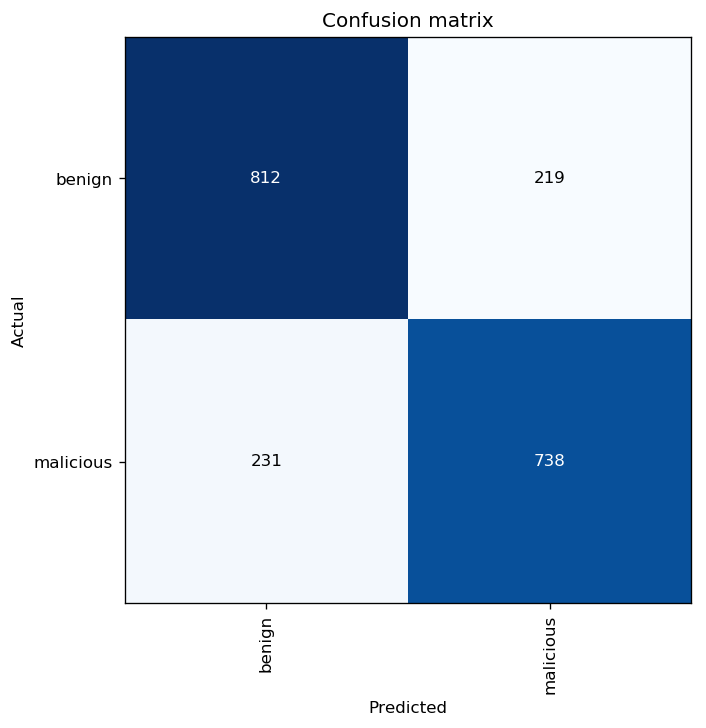

In [104]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [ ]:
def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals

X, y = get_proc_df(data)

# Label target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

In [ ]:
# Validation set
x_vals = np.concatenate([data.valid_dl.x.codes, data.valid_dl.x.conts], axis=1)
x_cols = data.valid_dl.x.cat_names + data.valid_dl.x.cont_names

X_valid = pd.DataFrame(data=x_vals, columns=x_cols)[
    [c for c in data.inner_df.columns if c in x_cols] ] # Retain order

# Reconstruct ys to apply log if specified
y_valid = np.array([i.obj for i in data.valid_dl.y])

# Label target
target_le = LabelEncoder()
y_valid = target_le.fit_transform(y_valid)

In [ ]:
# Parameters for Grid Search
param_grid = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_depth': [1, 4, 6, 8, 10, 14, 18, 22, 24, 26, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [5, 10, 12],
}

# Scoring for Grid Search
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

clf = RandomForestClassifier(
        criterion='entropy')

# Setup base Classifier and Grid Search
print('  * Initiating Malicious URL Model') 
rdf = GridSearchCV(clf, param_grid, scoring=scorers, refit='f1_score',
                   return_train_score=True, n_jobs=4)

# Fit model
print('  * Training Malicious URL Model') 
rdf.fit(X, y);

# Run predictions
print('  * Predicting test classes')     
rfprediction = rdf.predict(X_valid)  # predict output

# Calculate accuracy 
print('\n\n')
print('  * Performance testing:')
print("    Precision - %1.3f" % precision_score(y_valid, rfprediction))
print("    Recall - %1.3f" % recall_score(y_valid, rfprediction))
print("    F1 - %1.3f\n" % f1_score(y_valid, rfprediction))

# Confusion matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=rfprediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Benign', 'Malicious']
fig = plt.figure();
ax = fig.add_subplot(111);
cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
fig.colorbar(cax);
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);
plt.xlabel('Predicted');
plt.ylabel('Expected');

plt.show();

In [ ]:
# from sklearn import svm

# # Scoring for Grid Search
# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score),
#     'f1_score': make_scorer(f1_score)
# }

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas}
# grid_search = GridSearchCV(svm.SVC(kernel='linear'),  param_grid, scorers, refit='f1_score')
# grid_search.fit(X, y)

# # vc = svm.SVC(kernel='linear', C=1).fit(X, y)

# # # Fit model
# # print('  * Training Malicious URL Model') 
# # rdf.fit(X, y);

# # Run predictions
# print('  * Predicting test classes')     
# vcprediction = grid_search.predict(X_valid)  # predict output

# # Calculate accuracy 
# print('\n\n')
# print('  * Performance testing:')
# print("    Precision - %1.3f" % precision_score(y_valid, vcprediction))
# print("    Recall - %1.3f" % recall_score(y_valid, vcprediction))
# print("    F1 - %1.3f\n" % f1_score(y_valid, vcprediction))

# # Confusion matrix
# conf_mat = confusion_matrix(y_true=y_valid, y_pred=vcprediction)
# print('Confusion matrix:\n', conf_mat)

# labels = ['Benign', 'Malicious']
# fig = plt.figure();
# ax = fig.add_subplot(111);
# cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
# fig.colorbar(cax);
# ax.set_xticklabels([''] + labels);
# ax.set_yticklabels([''] + labels);
# plt.xlabel('Predicted');
# plt.ylabel('Expected');

# plt.show();

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, rfprediction)
roc_auc = auc(false_positive_rate, true_positive_rate)